# Loan Prediction

The company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. 

To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers. 

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import skew

In [4]:
# Read the training and test datasets
train = pd.read_csv('../root/input/train.csv')
test = pd.read_csv('../root/input/test.csv')

These are the customers' details available in the dataset.

* Variable - Description
* Loan_ID - Unique Loan ID
* Gender - Male/ Female
* Married - Applicant married (Y/N)
* Dependents - Number of dependents
* Education - Applicant Education (Graduate/ Under Graduate)
* Self_Employed - Self employed (Y/N)
* ApplicantIncome - Applicant income
* CoapplicantIncome - Coapplicant income
* LoanAmount - Loan amount in thousands
* Loan_Amount_Term - Term of loan in months
* Credit_History - credit history meets guidelines
* Property_Area - Urban/ Semi Urban/ Rural
* Loan_Status - Loan approved (Y/N)

## Data Exploration

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [7]:
train.describe(include='all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614,601,611,599,614,582,614.000000,614.000000,592.000000,600.00000,564.000000,614,614
unique,614,2,2,4,2,2,NaN,NaN,NaN,NaN,NaN,3,2
top,LP001002,Male,Yes,0,Graduate,No,NaN,NaN,NaN,NaN,NaN,Semiurban,Y
freq,1,489,398,345,480,500,NaN,NaN,NaN,NaN,NaN,233,422
mean,NaN,NaN,NaN,NaN,NaN,NaN,5403.459283,1621.245798,146.412162,342.00000,0.842199,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,6109.041673,2926.248369,85.587325,65.12041,0.364878,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,0.000000,9.000000,12.00000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2877.500000,0.000000,100.000000,360.00000,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3812.500000,1188.500000,128.000000,360.00000,1.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5795.000000,2297.250000,168.000000,360.00000,1.000000,NaN,NaN


In [8]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Loan ID

In [9]:
# Remove the 'Loan_ID' column from the training dataset
train.drop(['Loan_ID'], axis=1, inplace=True)

# Store the 'Loan_ID' column of the test dataset in a separate variable
test_id = test.Loan_ID

# Remove the 'Loan_ID' column from the test dataset
test.drop(['Loan_ID'], axis=1, inplace=True)

### Gender

In [10]:
train.Gender.value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

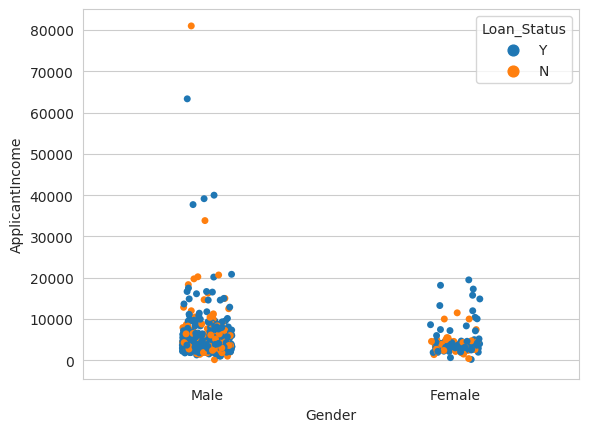

In [11]:
# Create a strip plot to analyze the relationship between 'Gender', 'ApplicantIncome', and 'Loan_Status'
sns.stripplot(x="Gender", y="ApplicantIncome", data=train, hue='Loan_Status', jitter=True)

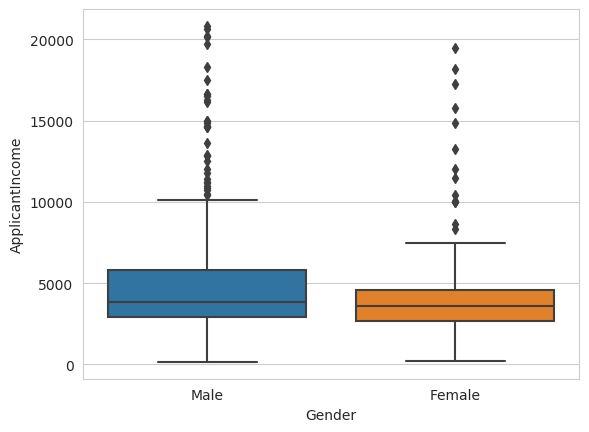

In [12]:
# Create a box plot to analyze the relationship between 'Gender', 'ApplicantIncome', and 'Loan_Status'
sns.boxplot(x='Gender', y='ApplicantIncome', data=train.loc[train.ApplicantIncome < 25000])

In [13]:
# Group the data by 'Gender' and calculate the normalized value counts of 'Loan_Status'
train.groupby(['Gender'])['Loan_Status'].value_counts(normalize=True)

Gender  Loan_Status
Female  Y              0.669643
        N              0.330357
Male    Y              0.693252
        N              0.306748
Name: Loan_Status, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


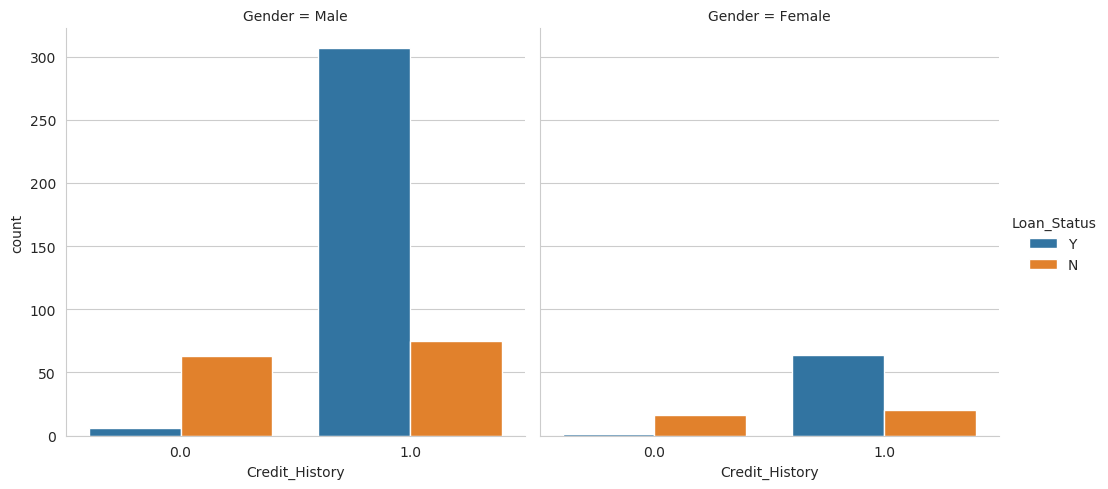

In [14]:
# Create a factor plot to analyze the relationship between 'Credit_History', 'Loan_Status', and 'Gender'
sns.factorplot(x="Credit_History", hue="Loan_Status", col="Gender", data=train, kind="count")

In [15]:
train['Gender'].fillna('Male', inplace=True)
test['Gender'].fillna('Male', inplace=True)

### Married

In [16]:
train.Married.value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [17]:
# Create a cross-tabulation table to analyze the relationship between 'Married' and 'Loan_Status'
pd.crosstab(train.Married, train.Loan_Status)

Loan_Status,N,Y
Married,,
No,79,134
Yes,113,285


In [18]:
# Group the data by 'Gender' and calculate the normalized value counts of 'Married'
train.groupby(['Gender'])['Married'].value_counts(normalize=True)

Gender  Married
Female  No         0.720721
        Yes        0.279279
Male    Yes        0.734000
        No         0.266000
Name: Married, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


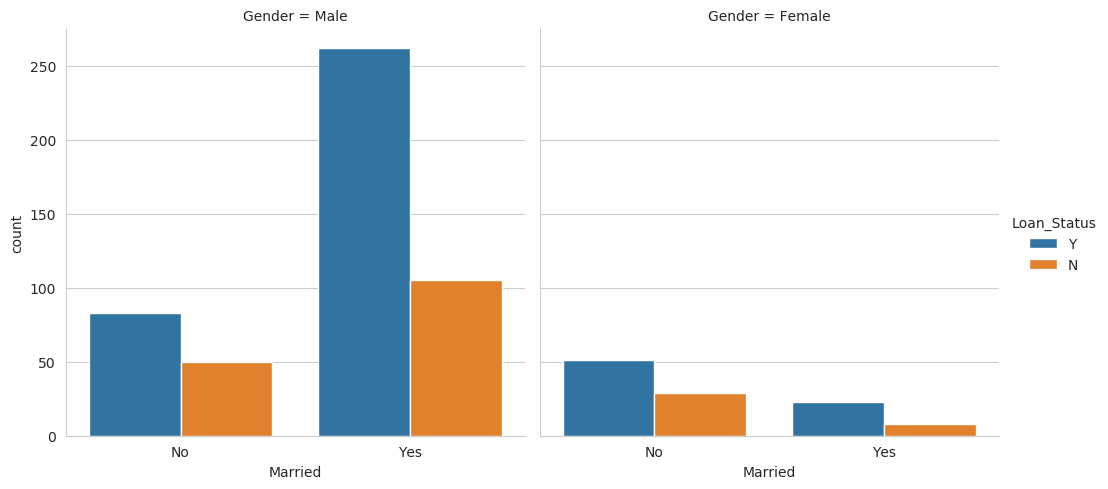

In [19]:
# Create a factor plot to analyze the relationship between 'Married', 'Loan_Status', and 'Gender'
sns.factorplot(x="Married", hue="Loan_Status", col="Gender", data=train, kind="count")

In [20]:
# Filter the 'train' DataFrame to retrieve rows where 'Married' is null
train.loc[train.Married.isnull() == True]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


In [21]:
# Update the 'Married' column in the 'train' DataFrame based on specific conditions
train.loc[(train.Gender == 'Male') & (train.Married.isnull() == True), 'Married'] = 'Yes'
train.loc[(train.Gender == 'Female') & (train.Married.isnull() == True), 'Married'] = 'No'

### Dependents

In [22]:
train.Dependents.value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [23]:
# Group the data by 'Dependents' and calculate the normalized value counts of 'Loan_Status'
train.groupby(['Dependents'])['Loan_Status'].value_counts(normalize=True)

Dependents  Loan_Status
0           Y              0.689855
            N              0.310145
1           Y              0.647059
            N              0.352941
2           Y              0.752475
            N              0.247525
3+          Y              0.647059
            N              0.352941
Name: Loan_Status, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


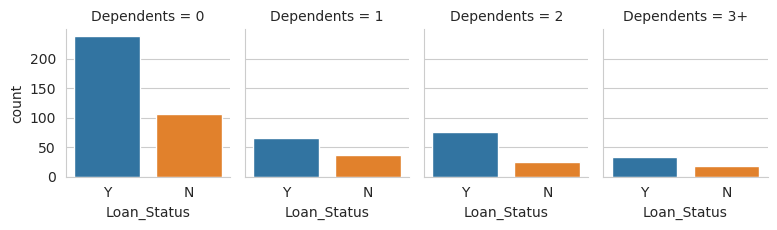

In [24]:
# Create a factor plot to analyze the relationship between 'Loan_Status', 'Dependents', and column wrapping
sns.factorplot("Loan_Status", col="Dependents", col_wrap=4, data=train, kind="count", size=2.4, aspect=.8)

In [25]:
train.groupby(['Gender', 'Married', 'Property_Area'])['Dependents'].value_counts(normalize=True)

Gender  Married  Property_Area  Dependents
Female  No       Rural          0             0.842105
                                1             0.105263
                                3+            0.052632
                 Semiurban      0             0.735294
                                1             0.235294
                                2             0.029412
                 Urban          0             0.760000
                                1             0.120000
                                3+            0.080000
                                2             0.040000
        Yes      Rural          0             1.000000
                 Semiurban      0             0.650000
                                1             0.200000
                                2             0.150000
                 Urban          0             0.333333
                                1             0.333333
                                2             0.333333
Male    No       Rural

In [26]:
train['Dependents'] = train['Dependents'].fillna(train['Dependents'].mode().iloc[0])
test['Dependents'] = test['Dependents'].fillna(test['Dependents'].mode().iloc[0])

### Education

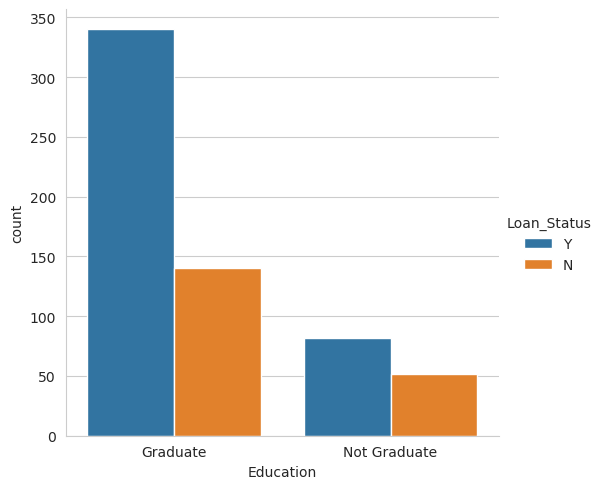

In [27]:
sns.factorplot(x="Education", hue="Loan_Status", data=train, kind="count")

### Self_Employed

In [28]:
train.groupby(['Self_Employed'])['Loan_Status'].value_counts(normalize=True)

Self_Employed  Loan_Status
No             Y              0.686000
               N              0.314000
Yes            Y              0.682927
               N              0.317073
Name: Loan_Status, dtype: float64

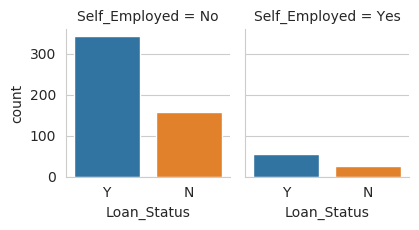

In [29]:
sns.factorplot("Loan_Status", col="Self_Employed", col_wrap=4, data=train, kind="count", size=2.4, aspect=.8)

In [30]:
train.groupby(['Education', 'Married', 'Dependents', 'Gender', 'Property_Area'])['Self_Employed'].apply(lambda x: x.mode())

Education     Married  Dependents  Gender  Property_Area   
Graduate      No       0           Female  Rural          0    No
                                           Semiurban      0    No
                                           Urban          0    No
                                   Male    Rural          0    No
                                           Semiurban      0    No
                                                               ..
Not Graduate  Yes      2           Male    Semiurban      0    No
                                           Urban          0    No
                       3+          Male    Rural          0    No
                                           Semiurban      0    No
                                           Urban          0    No
Name: Self_Employed, Length: 67, dtype: object

In [31]:
# Update the 'Self_Employed' column in the 'train' DataFrame based on specific conditions
train.loc[(train.Education == 'Graduate') & (train.Married == 'Yes')
          & (train.Dependents == '2') & (train.Gender == 'Male') & (train.Property_Area == 'Urban')
          & (train.Self_Employed.isnull() == True), 'Self_Employed'] = 'Yes'

# Update the 'Self_Employed' column in the 'test' DataFrame based on specific conditions
test.loc[(test.Education == 'Graduate') & (test.Married == 'Yes')
         & (test.Dependents == '2') & (test.Gender == 'Male') & (test.Property_Area == 'Urban')
         & (test.Self_Employed.isnull() == True), 'Self_Employed'] = 'Yes'

# Fill missing values in 'Self_Employed' column with 'No' in the 'train' DataFrame
train['Self_Employed'].fillna('No', inplace=True)

# Fill missing values in 'Self_Employed' column with 'No' in the 'test' DataFrame
test['Self_Employed'].fillna('No', inplace=True)

### ApplicantIncome

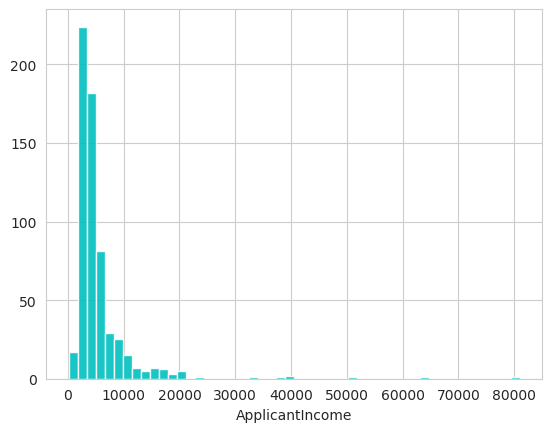

In [33]:
# Create a distribution plot for 'ApplicantIncome' in the 'train' DataFrame
sns.distplot(train['ApplicantIncome'], kde=False, color='c', hist_kws={'alpha': 0.9})

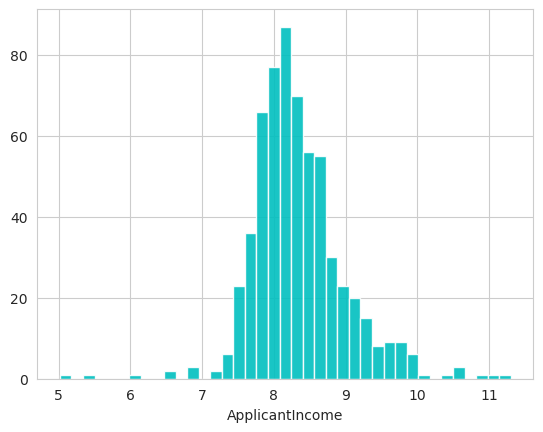

In [34]:
# Create a distribution plot for the log-transformed 'ApplicantIncome' in the 'train' DataFrame
sns.distplot(np.log1p(train['ApplicantIncome']), kde=False, color='c', hist_kws={'alpha': 0.9})

In [35]:
# Create an 'Income_group' column in the 'train' DataFrame based on 'ApplicantIncome' quartiles
train['Income_group'] = pd.qcut(train.ApplicantIncome, 10, labels=[0,1,2,3,4,5,6,7,8,9])

# Create an 'Income_group' column in the 'test' DataFrame based on 'ApplicantIncome' quartiles
test['Income_group'] = pd.qcut(test.ApplicantIncome, 10, labels=[0,1,2,3,4,5,6,7,8,9])

In [36]:
# Convert the 'Income_group' column to string type in the 'train' DataFrame
train['Income_group'] = train['Income_group'].astype(str)

# Convert the 'Income_group' column to string type in the 'test' DataFrame
test['Income_group'] = test['Income_group'].astype(str)

In [37]:
train.groupby(['Income_group'])['Loan_Status'].value_counts(normalize=True)

Income_group  Loan_Status
0             Y              0.661290
              N              0.338710
1             Y              0.721311
              N              0.278689
2             Y              0.704918
              N              0.295082
3             Y              0.709677
              N              0.290323
4             Y              0.639344
              N              0.360656
5             Y              0.737705
              N              0.262295
6             Y              0.612903
              N              0.387097
7             Y              0.721311
              N              0.278689
8             Y              0.688525
              N              0.311475
9             Y              0.677419
              N              0.322581
Name: Loan_Status, dtype: float64

### CoapplicantIncome

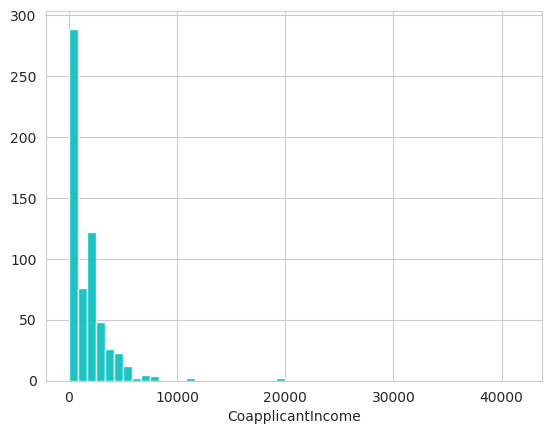

In [38]:
sns.distplot(train['CoapplicantIncome'], kde=False, color='c', hist_kws={'alpha': 0.9})

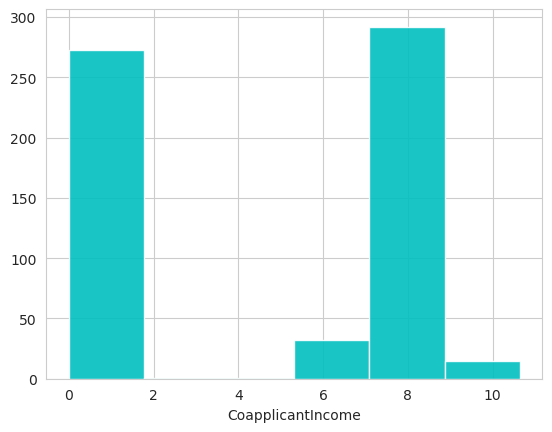

In [39]:
sns.distplot(np.log1p(train['CoapplicantIncome']), kde=False, color='c', hist_kws={'alpha': 0.9})

In [40]:
# Create a 'Coap_group' column in the 'train' DataFrame based on 'CoapplicantIncome' quartiles
train['Coap_group'] = pd.qcut(train.CoapplicantIncome, 2, labels=[0,1])

# Create a 'Coap_group' column in the 'test' DataFrame based on 'CoapplicantIncome' quartiles
test['Coap_group'] = pd.qcut(test.CoapplicantIncome, 2, labels=[0,1])

In [41]:
# Convert the 'Coap_group' column to string type in the 'train' DataFrame
train['Coap_group'] = train['Coap_group'].astype(str)

# Convert the 'Coap_group' column to string type in the 'test' DataFrame
test['Coap_group'] = test['Coap_group'].astype(str)

In [42]:
train.groupby(['Coap_group'])['Loan_Status'].value_counts(normalize=True)

Coap_group  Loan_Status
0           Y              0.677524
            N              0.322476
1           Y              0.697068
            N              0.302932
Name: Loan_Status, dtype: float64

### LoanAmount

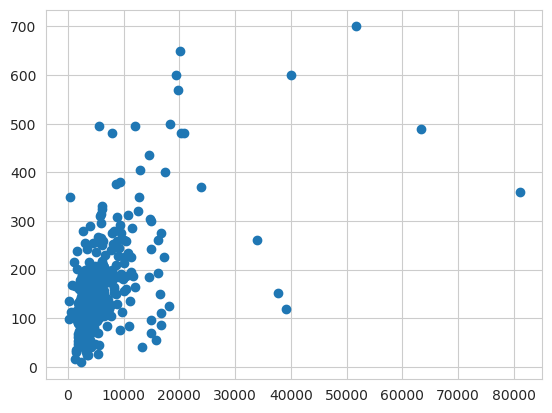

In [43]:
plt.scatter(train['ApplicantIncome'], train['LoanAmount'])

In [44]:
train.groupby(['Education', 'Gender', 'Income_group', 'Self_Employed'])['LoanAmount'].median()

Education     Gender  Income_group  Self_Employed
Graduate      Female  0             No               113.0
                      1             No               100.0
                                    Yes               96.0
                      2             No                87.0
                      3             No               102.5
                                                     ...  
Not Graduate  Male    6             Yes               96.0
                      7             No               161.0
                                    Yes              131.0
                      8             No               130.0
                                    Yes              156.0
Name: LoanAmount, Length: 61, dtype: float64

In [45]:
train.groupby(['Education', 'Gender', 'Self_Employed'])['LoanAmount'].median()

Education     Gender  Self_Employed
Graduate      Female  No               113.0
                      Yes              127.5
              Male    No               134.0
                      Yes              160.0
Not Graduate  Female  No               100.0
                      Yes              131.5
              Male    No               113.0
                      Yes              130.0
Name: LoanAmount, dtype: float64

In [46]:
# Fill missing values in 'LoanAmount' column in the 'train' DataFrame based on grouped means
train['LoanAmount'] = train.groupby(['Education', 'Gender', 'Income_group', 'Self_Employed'])['LoanAmount'].apply(lambda x: x.fillna(x.mean()))

# Fill missing values in 'LoanAmount' column in the 'test' DataFrame based on grouped means
test['LoanAmount'] = test.groupby(['Education', 'Gender', 'Income_group', 'Self_Employed'])['LoanAmount'].apply(lambda x: x.fillna(x.mean()))

# Fill missing values in 'LoanAmount' column in the 'train' DataFrame based on grouped means
train['LoanAmount'] = train.groupby(['Education', 'Gender', 'Self_Employed'])['LoanAmount'].apply(lambda x: x.fillna(x.mean()))

# Fill missing values in 'LoanAmount' column in the 'test' DataFrame based on grouped means
test['LoanAmount'] = test.groupby(['Education', 'Gender', 'Self_Employed'])['LoanAmount'].apply(lambda x: x.fillna(x.mean()))

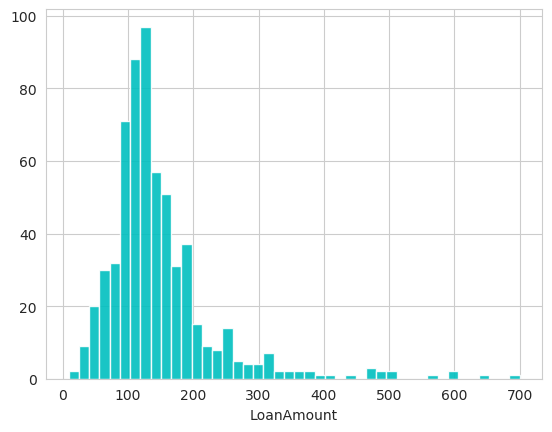

In [47]:
sns.distplot(train['LoanAmount'], kde=False, color='c', hist_kws={'alpha': 0.9})

In [48]:
train['Loan_group'] =  pd.qcut(train.LoanAmount, 10, labels=[0,1,2,3,4,5,6,7,8,9])
test['Loan_group'] =  pd.qcut(test.LoanAmount, 10, labels=[0,1,2,3,4,5,6,7,8,9])
train['Loan_group'] = train['Loan_group'].astype(str)
test['Loan_group'] = test['Loan_group'].astype(str)

### Loan_Amount_Term

In [49]:
train.Loan_Amount_Term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

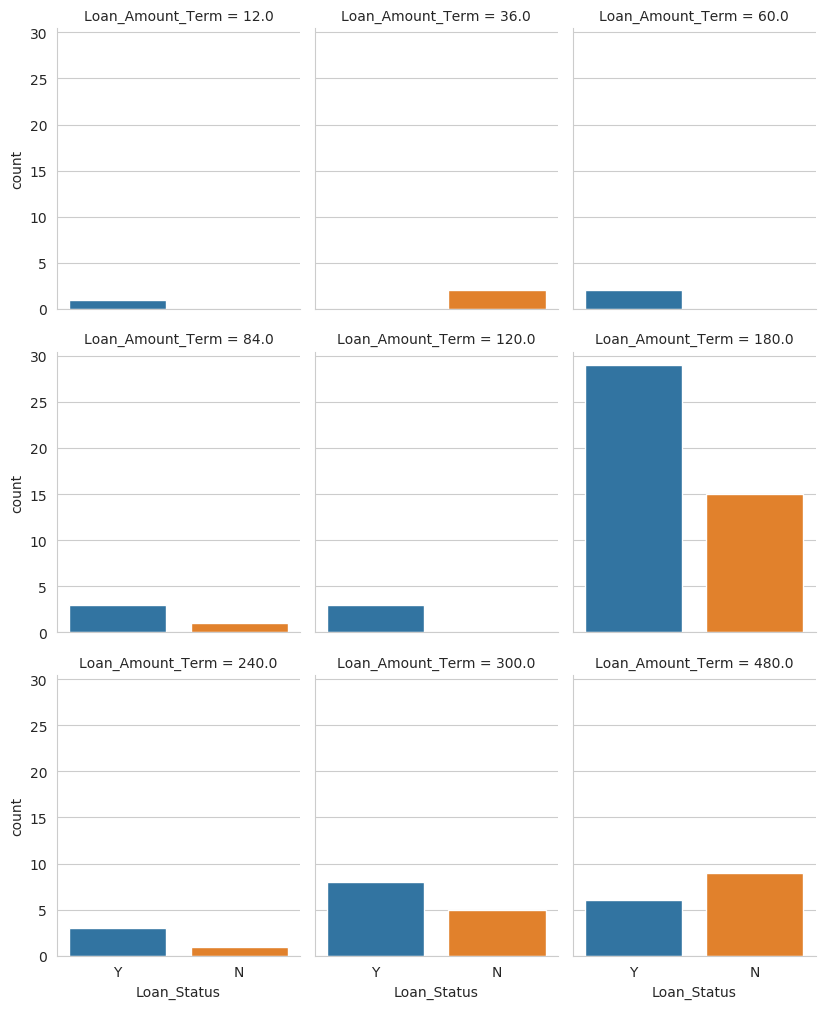

In [50]:
# Create a factor plot to analyze the relationship between 'Loan_Status', 'Loan_Amount_Term', and column wrapping
sns.factorplot("Loan_Status", col="Loan_Amount_Term", col_wrap=3,
               data=train.loc[train.Loan_Amount_Term != 360.], kind="count", size=3.4, aspect=.8)

In [51]:
train.groupby(['Education', 'Income_group', 'Loan_group'])['Loan_Amount_Term'].apply(lambda x: x.mode())

Education     Income_group  Loan_group   
Graduate      0             0           0    360.0
                            1           0    360.0
                            2           0    360.0
                            3           0    360.0
                            4           0    360.0
                                             ...  
Not Graduate  8             4           1    360.0
                            5           0    360.0
                            8           0    360.0
              9             4           0    360.0
                            8           0    360.0
Name: Loan_Amount_Term, Length: 157, dtype: float64

In [52]:
train['Loan_Amount_Term'].fillna(360.0, inplace=True)
test['Loan_Amount_Term'].fillna(360.0, inplace=True)
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].astype(str)
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].astype(str)

### Credit_History

In [53]:
train.Credit_History.value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [54]:
train.groupby(['Education', 'Self_Employed', 'Property_Area', 'Income_group'])['Credit_History'].apply(lambda x: x.mode())

Education     Self_Employed  Property_Area  Income_group   
Graduate      No             Rural          0             0    1.0
                                            1             0    1.0
                                            2             0    1.0
                                            3             0    1.0
                                            4             0    1.0
                                                              ... 
Not Graduate  Yes            Semiurban      9             0    1.0
                             Urban          5             0    0.0
                                            6             0    1.0
                                            8             0    1.0
                                            9             0    1.0
Name: Credit_History, Length: 94, dtype: float64

In [55]:
# Update the 'Self_Employed' column in the 'train' DataFrame based on specific conditions
train.loc[(train.Education == 'Graduate') & (train.Self_Employed == 'Yes')
          & (train.Property_Area == 'Urban') & (train.Income_group == '9') & (train.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0
train.loc[(train.Education == 'Not Graduate') & (train.Self_Employed == 'No')
          & (train.Property_Area == 'Rural') & (train.Income_group == '7') & (train.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0
train.loc[(train.Education == 'Not Graduate') & (train.Self_Employed == 'No')
          & (train.Property_Area == 'Urban') & (train.Income_group == '2') & (train.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0

# Update the 'Self_Employed' column in the 'test' DataFrame based on specific conditions
test.loc[(test.Education == 'Graduate') & (test.Self_Employed == 'Yes')
          & (test.Property_Area == 'Urban') & (test.Income_group == '9') & (test.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0
test.loc[(test.Education == 'Not Graduate') & (test.Self_Employed == 'No')
          & (test.Property_Area == 'Rural') & (test.Income_group == '7') & (test.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0
test.loc[(test.Education == 'Not Graduate') & (test.Self_Employed == 'No')
          & (test.Property_Area == 'Urban') & (test.Income_group == '2') & (test.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0

# Fill missing values in 'Credit_History' column with 1.0 in the 'train' DataFrame
train['Credit_History'].fillna(1.0, inplace=True)

# Fill missing values in 'Credit_History' column with 1.0 in the 'test' DataFrame
test['Credit_History'].fillna(1.0, inplace=True)

# Convert the 'Credit_History' column to string type in the 'train' DataFrame
train['Credit_History'] = train['Credit_History'].astype(str)

# Convert the 'Credit_History' column to string type in the 'test' DataFrame
test['Credit_History'] = test['Credit_History'].astype(str)

### Property_Area

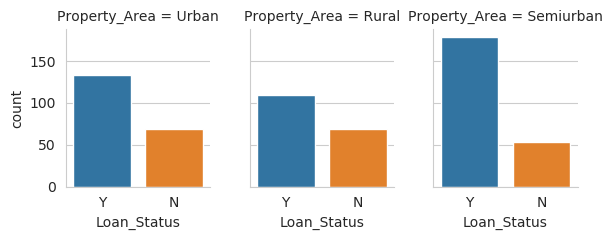

In [56]:
sns.factorplot('Loan_Status', col='Property_Area', col_wrap=3, data=train, kind='count', size=2.5, aspect=.8)

## Data Preparation

In [57]:
train.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term      object
Credit_History        object
Property_Area         object
Loan_Status           object
Income_group          object
Coap_group            object
Loan_group            object
dtype: object

In [58]:
# Perform feature transformation and encoding on the 'train' DataFrame
for col in train.columns.drop('Loan_Status'):
    if train[col].dtype != 'object':
        if skew(train[col]) > 0.75:
            # Log-transform the column if the skewness is above the threshold
            train[col] = np.log1p(train[col])
        pass
    else:
        # Perform one-hot encoding for categorical columns
        dummies = pd.get_dummies(train[col], drop_first=False)
        dummies = dummies.add_prefix("{}_".format(col))
        if col == 'Credit_History' or col == 'Loan_Amount_Term':
            pass
        else:
            # Drop the original column if it's not 'Credit_History' or 'Loan_Amount_Term'
            train.drop(col, axis=1, inplace=True)
        # Join the encoded columns to the 'train' DataFrame
        train = train.join(dummies)

# Perform feature transformation and encoding on the 'test' DataFrame
for col in test.columns:
    if test[col].dtype != 'object':
        if skew(test[col]) > 0.75:
            # Log-transform the column if the skewness is above the threshold
            test[col] = np.log1p(test[col])
        pass
    else:
        # Perform one-hot encoding for categorical columns
        dummies = pd.get_dummies(test[col], drop_first=False)
        dummies = dummies.add_prefix("{}_".format(col))
        if col == 'Credit_History' or col == 'Loan_Amount_Term':
            pass
        else:
            # Drop the original column if it's not 'Credit_History' or 'Loan_Amount_Term'
            test.drop(col, axis=1, inplace=True)
        # Join the encoded columns to the 'test' DataFrame
        test = test.join(dummies)

In [59]:
train['Credit_History'] = train['Credit_History'].astype(float)
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].astype(float)
test['Credit_History'] = test['Credit_History'].astype(float)
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].astype(float)

In [60]:
X_train = train.drop('Loan_Status', axis=1)
le = LabelEncoder()
Y_train = le.fit_transform(train.Loan_Status.values)
X_test = test

In [61]:
# Instantiate and fit a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, Y_train)

# Get the feature importances and indices
indices = np.argsort(clf.feature_importances_)[::-1]

# Print the feature ranking
print('Feature ranking:')
for f in range(X_train.shape[1]):
    print('%d. feature %d %s (%f)' % (f + 1, indices[f], X_train.columns[indices[f]],
                                      clf.feature_importances_[indices[f]]))

Feature ranking:
1. feature 29 Credit_History_1.0 (0.106865)
2. feature 0 ApplicantIncome (0.105786)
3. feature 2 LoanAmount (0.098055)
4. feature 28 Credit_History_0.0 (0.089134)
5. feature 4 Credit_History (0.076789)
6. feature 1 CoapplicantIncome (0.066451)
7. feature 31 Property_Area_Semiurban (0.018958)
8. feature 3 Loan_Amount_Term (0.018692)
9. feature 9 Dependents_0 (0.017279)
10. feature 30 Property_Area_Rural (0.017107)
11. feature 39 Income_group_6 (0.016280)
12. feature 32 Property_Area_Urban (0.014866)
13. feature 7 Married_No (0.014506)
14. feature 52 Loan_group_7 (0.014401)
15. feature 10 Dependents_1 (0.014400)
16. feature 8 Married_Yes (0.014052)
17. feature 13 Education_Graduate (0.012374)
18. feature 43 Coap_group_0 (0.011808)
19. feature 6 Gender_Male (0.011784)
20. feature 46 Loan_group_1 (0.011686)
21. feature 14 Education_Not Graduate (0.011527)
22. feature 5 Gender_Female (0.011362)
23. feature 38 Income_group_5 (0.011277)
24. feature 37 Income_group_4 (0.010735

In [62]:
# Select the top 6 features based on their importance scores
best_features = X_train.columns[indices[0:6]]

# Subset the training and testing data with the best features
X = X_train[best_features]
Xt = X_test[best_features]

## Modelling

In [63]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y_train, test_size=0.20, random_state=36)

In [65]:
# Instantiate a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, criterion='gini')

# Instantiate a Calibrated Classifier with isotonic calibration and 5-fold cross-validation
calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)

# Fit the calibrated classifier to the training data
calibrated_clf.fit(Xtrain, ytrain)

# Predict the probabilities for the validation set
y_val = calibrated_clf.predict_proba(Xtest)

# Convert the predicted probabilities to binary labels based on a threshold of 0.5
y_f = [1 if y_val[i][0] < 0.5 else 0 for i in range(len(ytest))]

# Calculate the accuracy of the predictions
accuracy = sum(y_f == ytest) / len(ytest)

accuracy

0.7804878048780488

In [66]:
# Instantiate a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, criterion='gini')

# Instantiate a Calibrated Classifier with isotonic calibration and 5-fold cross-validation
calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)

# Fit the calibrated classifier to the training data
calibrated_clf.fit(X, Y_train)

# Predict the probabilities for the test set
y_submit = calibrated_clf.predict_proba(Xt)

In [67]:
# Convert predicted probabilities to binary labels
y_pred = le.inverse_transform([1 if y_submit[i][0] < 0.5 else 0 for i in range(len(Xt))])

# Create submission DataFrame
submission = pd.DataFrame({'Loan_ID': test_id, 'Loan_Status': y_pred})

# Save submission to CSV file
submission.to_csv('loan.csv', index=False)